<h2> Adding New Segmenters and Features </h2>
<p> To try and make this general tool modular, the method of perfomring segmentation and adding region based features is built using an abstract class. This will be discussed with an example implemented here </p>

In [1]:
# Import segmenter and a path to an image
from facet_ml.segmentation import segmenter
from pathlib import Path
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

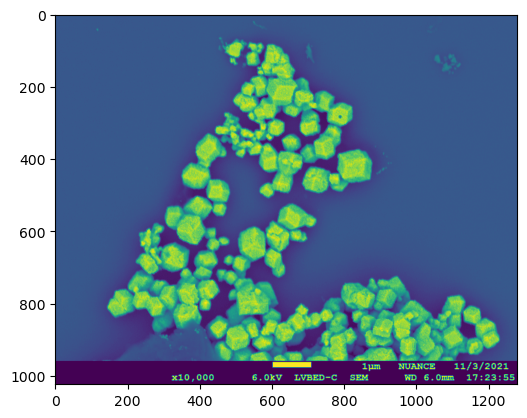

In [2]:
# Define an Image to open
working_dir = Path(os.path.abspath(""))
image_dir = working_dir.parent / "Images"
image_paths = list(image_dir.rglob("*"))
image_path_oi = str(image_paths[0])

image = cv2.imread(image_path_oi,0)
plt.imshow(image)

<hr>
<p> Creating a variation on AbstractSegmenter only requires that marked regions get created in "markers_filled." For visualization purposes in applets, "threshold" is also required to help understand the data.</p>
<p> To demonstrate, we create a simple region finder that just erodes pixels greater than the mean and attempts to say any now separate spot is a distinct region. </p>

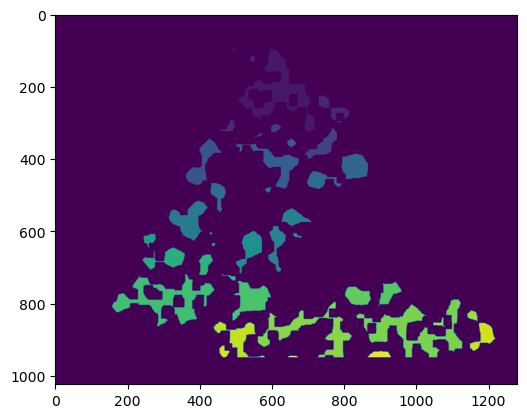

In [3]:
class HalfErodeSegmenter(segmenter.AbstractSegmenter):

    def __init__(self,
                 image):
        super().__init__(image)

    @property
    def thresh(self):
        '''
        The way an image creates a "pixel or not" image. Required for algorithmic segmenters for Watershed,
        but not necessarily for others
        '''
        raise NotImplemented

    @property
    def markers(self):
        '''
        The way regions are seeded. Not required, but can help with some visualizations
        '''
        raise NotImplemented

    @property
    def markers_filled(self):
        '''
        REQUIRED
        This is how regions are created. 
        self._label_increment is used internally to help separate these values from the actual regions of interest
        '''
        avg_intensity = np.mean(image)
        image_logical = (self.image > avg_intensity).astype(np.uint8)
        eroded_image = cv2.erode(image_logical, np.ones((3,3)),iterations=10)

        outputs = cv2.connectedComponentsWithStats(eroded_image)
        markers = outputs[1] + self._label_increment

        return markers
        

hes = HalfErodeSegmenter(image=image)
plt.imshow(hes.markers_filled)

<p> The ImageSegmenter class should now be able to run it just fine to get measurements </p>

In [4]:
image_segmenter = segmenter.ImageSegmenter(image_path_oi, segmenter=HalfErodeSegmenter)
image_segmenter.df.head(5)

C:\Users\Jacob\Desktop\Academics\Mirkin\colloidal_crystal_ML\facet_ml\segmentation\segmenter.py:727: RuntimeWarning: invalid value encountered in divide
  clusters["major_axis_length"] / clusters["minor_axis_length"]
C:\Users\Jacob\Desktop\Academics\Mirkin\colloidal_crystal_ML\facet_ml\segmentation\segmenter.py:730: RuntimeWarning: invalid value encountered in divide
  clusters["perimeter"] / clusters["major_axis_length"]
C:\Users\Jacob\Desktop\Academics\Mirkin\colloidal_crystal_ML\facet_ml\segmentation\segmenter.py:733: RuntimeWarning: invalid value encountered in divide
  clusters["perimeter"] / clusters["minor_axis_length"]
C:\Users\Jacob\Desktop\Academics\Mirkin\colloidal_crystal_ML\facet_ml\segmentation\features.py:521: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(rotated_x, rotated_y, 2)
C:\Users\Jacob\Desktop\Academics\Mirkin\colloidal_crystal_ML\facet_ml\segmentation\features.py:521: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(ro

,area,equivalent_diameter,orientation,major_axis_length,minor_axis_length,perimeter,min_intensity,mean_intensity,max_intensity,solidity,...,Filename,Region,mean_curvature,std_curvature,min_curvature,max_curvature,percent_convexity_curvature,longest_contiguous_percent_concavity_curvature,longest_contiguous_percent_convexity_curvature,number_distinct_paths_curvature
0,2.335398e+04,172.438989,-1.149429,224.221700,166.534145,709.294803,202.0,218.218045,242.0,0.791667,...,c:\Users\Jacob\Desktop\Academics\Mirkin\colloi...,1,0.079624,0.413898,-0.546348,3.726566,60.000000,9.473684,21.052632,18.0
1,3.248485e+03,64.312518,-1.054604,79.546126,54.751621,200.984134,135.0,176.459459,206.0,0.973684,...,c:\Users\Jacob\Desktop\Academics\Mirkin\colloi...,2,0.431471,1.243473,-0.860726,6.382979,55.172414,6.896552,10.344828,22.0
2,1.224416e+06,1248.588931,0.758621,2053.194380,1721.638569,12897.534914,93.0,203.457837,255.0,0.487162,...,c:\Users\Jacob\Desktop\Academics\Mirkin\colloi...,3,-0.001243,0.099470,-0.984451,0.886116,56.912029,4.608019,6.044285,170.0
3,1.536446e+04,139.866489,-0.135396,168.333439,119.312696,472.105354,190.0,217.880000,240.0,0.930851,...,c:\Users\Jacob\Desktop\Academics\Mirkin\colloi...,4,0.099548,0.283783,-1.193028,0.707725,73.015873,9.523810,19.047619,12.0
4,1.690968e+05,464.005140,1.021102,1043.493591,376.046482,2908.809684,131.0,208.584112,250.0,0.566971,...,c:\Users\Jacob\Desktop\Academics\Mirkin\colloi...,5,0.016114,0.087540,-0.328880,0.499306,61.971831,16.056338,21.690141,12.0


<hr>
<p> To create cusotm featurizers, it is easiest to add them as a new Region featurizer </p>
<p> Functionally, a Region is an image mask, and a RegionFeaturizer analyzes the pixels in said mask and returns a value. </p>

([], [])

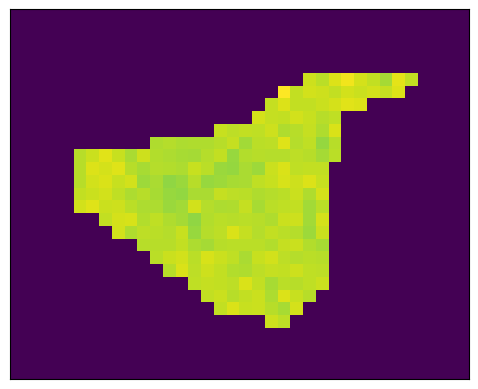

In [5]:
from facet_ml.segmentation.features import BaseRegionFeaturizer, Region
quick_region = Region(image_segmenter.region_arr[0])
plt.imshow(quick_region.region)
plt.xticks([]); plt.yticks([])

<p> We can create a class from the BaseRegionFeaturizer that then operates on the region </p>

In [10]:
class AverageIntensity(BaseRegionFeaturizer):

    def __init__(self):
        super().__init__()

    def apply_featurizer(self,my_region):
        region = my_region.region
        return np.mean( region[np.where(region > 0)] )
    
    @property
    def feature_name(self):
        return "AverageIntensity"

featurizer = AverageIntensity()
print(f"{featurizer.feature_name} : {featurizer.apply_featurizer(quick_region):.2f}")

AverageIntensity : 218.22


<p> We can add this to the ImageSegmenter to control which addidtional features are used </p>

In [12]:
modified_image_segmenter = segmenter.ImageSegmenter(image_path_oi,
                                                    region_featurizers=[AverageIntensity()]
                                                    )
modified_image_segmenter.df.head(5)["AverageIntensity"]

0    209.017844
1    199.011122
2    191.994731
3    217.210445
4    190.913802
Name: AverageIntensity, dtype: float64

<p> Combined, the simple customizations to Segmenter and RegionFeaturizer allow quick features ot be added to the pipeline</p>
<p> With the built-in labeling tool, this can help quickly go through and label images </p>